# Imports

In [1]:
# inspect python version
import platform
print("Python Version", platform.python_version_tuple())

Python Version ('3', '6', '9')


In [2]:
# Check if in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print("IN_COLAB", IN_COLAB)

if IN_COLAB:
    # Mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
    # drive.mount('/content/drive', force_remount=True)

    # update path to import modules from a folder in google drive.
    PROJECT_PATH = '/content/drive/My Drive/Unterlagen/MeinStudium/(6)_WiSe 2019-2020/Bachelor/BaBa/'
    sys.path.append(PROJECT_PATH)

    TORCH_DEVICE = 'cuda'
else:
    PROJECT_PATH = ''
    TORCH_DEVICE = 'cpu'

IN_COLAB True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# torch
import torch
import torch.nn as nn
print("PyTorch Version", torch.__version__, "GPU", torch.cuda.get_device_name(), "GPU Capability",
      torch.cuda.get_device_capability(), "CUDA Version", torch.version.cuda,
      "CUDA available", torch.cuda.is_available())

PyTorch Version 1.4.0 GPU Tesla P100-PCIE-16GB GPU Capability (6, 0) CUDA Version 10.1 CUDA available True


In [4]:
!pip install ipython-autotime
%load_ext autotime

In [5]:
# other modules
import os
import time
import math
import numpy as np
import collections
import PIL.Image
from ipywidgets import IntProgress
import imageio
import cv2
from collections import OrderedDict

import IPython.display
import IPython
print("IPython", IPython.__version__)

import matplotlib
print("matplotlib", matplotlib.__version__)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
if IN_COLAB:
    %matplotlib inline
else:
    %matplotlib notebook

import sklearn.metrics
from skimage import measure

IPython 5.5.0
matplotlib 3.1.3
time: 413 ms


In [6]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
        <p>{value} / {max}</p>
    """.format(value=value, max=max))

time: 2.27 ms


# Load data

In [7]:
originalImagesPath = os.path.join(PROJECT_PATH, "inputImages/Atlaszeder/")
scribbleImagesPath = os.path.join(PROJECT_PATH, "scribbleData/Atlaszeder/")
segmentedImagesPath = os.path.join(PROJECT_PATH, "segmentedData/Atlaszeder/")
validationImagesPath = os.path.join(PROJECT_PATH, "validationData/Atlaszeder/")

time: 4.44 ms


In [8]:
filenameEvaluation = "DJI_0329.png"

files = [f for f in os.listdir(originalImagesPath) if os.path.isfile(os.path.join(originalImagesPath, f))]
files.sort()
permutation = np.random.permutation(len(files))
files = [files[i] for i in permutation]
indexOfEvaluationFile = files.index(filenameEvaluation[:-3] + "JPG")
files.append(files.pop(indexOfEvaluationFile))  # move the file for evaluation to the end
originalImagePaths = [os.path.join(originalImagesPath, filename) for filename in files]
print(originalImagePaths)

# get all scribble files related to originalImageFilename
files = [f for f in os.listdir(scribbleImagesPath) if os.path.isfile(os.path.join(scribbleImagesPath, f))]
files.sort()
files = [files[i] for i in permutation]
files.append(files.pop(indexOfEvaluationFile))  # move the file for evaluation to the end
scribbleImagePaths = [os.path.join(scribbleImagesPath, filename) for filename in files]
print(scribbleImagePaths)

# get validation file
validationImagePath = os.path.join(validationImagesPath, filenameEvaluation)
print(validationImagePath)

# read images
colorMatsOriginal = [imageio.imread(path) for path in originalImagePaths]
scribbleMatsOriginalWithAlpha = [imageio.imread(path) for path in scribbleImagePaths]
scribbleMatsOriginal = [mat[..., :3] for mat in scribbleMatsOriginalWithAlpha]  # get rid of alpha channel
validationMatOriginal = imageio.imread(validationImagePath)

# scale down
newSize = (729, 486)
colorMats = [cv2.resize(mat, dsize=newSize) for mat in colorMatsOriginal]
scribbleMatsOriginalWithAlpha = [cv2.resize(mat, dsize=newSize) for mat in scribbleMatsOriginalWithAlpha]
scribbleMats = [cv2.resize(mat, dsize=newSize) for mat in scribbleMatsOriginal]
validationMat = cv2.resize(validationMatOriginal, dsize=newSize)
validationMat = cv2.threshold(validationMat, 127, 255, cv2.THRESH_BINARY)[1]

['/content/drive/My Drive/Unterlagen/MeinStudium/(6)_WiSe 2019-2020/Bachelor/BaBa/inputImages/Atlaszeder/DJI_0195.JPG', '/content/drive/My Drive/Unterlagen/MeinStudium/(6)_WiSe 2019-2020/Bachelor/BaBa/inputImages/Atlaszeder/DJI_0215.JPG', '/content/drive/My Drive/Unterlagen/MeinStudium/(6)_WiSe 2019-2020/Bachelor/BaBa/inputImages/Atlaszeder/DJI_0239.JPG', '/content/drive/My Drive/Unterlagen/MeinStudium/(6)_WiSe 2019-2020/Bachelor/BaBa/inputImages/Atlaszeder/DJI_0184.JPG', '/content/drive/My Drive/Unterlagen/MeinStudium/(6)_WiSe 2019-2020/Bachelor/BaBa/inputImages/Atlaszeder/DJI_0287.JPG', '/content/drive/My Drive/Unterlagen/MeinStudium/(6)_WiSe 2019-2020/Bachelor/BaBa/inputImages/Atlaszeder/DJI_0315.JPG', '/content/drive/My Drive/Unterlagen/MeinStudium/(6)_WiSe 2019-2020/Bachelor/BaBa/inputImages/Atlaszeder/DJI_0316.JPG', '/content/drive/My Drive/Unterlagen/MeinStudium/(6)_WiSe 2019-2020/Bachelor/BaBa/inputImages/Atlaszeder/DJI_0238.JPG', '/content/drive/My Drive/Unterlagen/MeinStudium

# Prepare train data

In [9]:
def prepareColorData(colorMat_):
    # normalize colorMat_ and add padding
    colorMat_ = np.divide(colorMat_, 255.0)
    colorMat_ = np.moveaxis(colorMat_, 2, 0)  # fit to Network requirements NxCxHxW later    
    #print("colorMat_", colorMat_.shape)
    return colorMat_

def prepareScribbleData(scribbleMat_):
    scribbleMat_ = np.delete(scribbleMat_, 1, 2)  # 1(green) 2(axis for colors)
    scribbleMat_ = np.minimum(scribbleMat_, 1)  # interval [0, 1]
    scribbleMat_ = np.moveaxis(scribbleMat_, 2, 0)  # fit to Network requirements NxCxHxW later
    scribbleMat_ = np.where(np.logical_and(scribbleMat_[0] == 0, scribbleMat_[1] == 0), np.full(scribbleMat_[1].shape, 0.5), scribbleMat_[0])
    #print("scribbleMat_", scribbleMat_.shape)
    return scribbleMat_

#coordMat = np.indices((imageHeight, imageWidth)).transpose((1, 2, 0)).astype(np.float32)
#coordMat[:, :, 0] = coordMat[:, :, 0] / imageHeight
#coordMat[:, :, 1] = coordMat[:, :, 1] / imageWidth
#print("coordMat", coordMat.shape)


time: 10.1 ms


In [10]:
xs_Color = [prepareColorData(mat) for mat in colorMats]
ys = [prepareScribbleData(mat) for mat in scribbleMats]
xs_Color = np.array(xs_Color)
ys = np.array(ys)
print("xs_Color shape:", xs_Color.shape)
print("ys shape:", ys.shape)

# shuffle
#permutation = np.random.permutation(ys.shape[0])
#xs_Color = xs_Color[permutation]
#ys = ys[permutation]

# transform to torch tensors
tensor_xs_Color = torch.from_numpy(xs_Color).float()
tensor_ys = torch.from_numpy(ys).float()

tensor_ys = tensor_ys.unsqueeze(1)
print("tensor_ys shape unsqueezed:", tensor_ys.shape)

# split in data sets
tensor_xs_train_Color = tensor_xs_Color[:80, ...]
tensor_xs_test_Color = tensor_xs_Color[80:100, ...]
tensor_xs_eval_Color = tensor_xs_Color[100:, ...]
tensor_ys_train = tensor_ys[:80, ...]
tensor_ys_test = tensor_ys[80:100, ...]
tensor_ys_eval = tensor_ys[100:, ...]


train_dataset = torch.utils.data.TensorDataset(tensor_xs_train_Color, tensor_ys_train) # create datset
params = {'batch_size': 5,
          'shuffle': True,
          'num_workers': 6}
train_dataloader = torch.utils.data.DataLoader(train_dataset, **params) # create dataloader

xs_Color shape: (101, 3, 486, 729)
ys shape: (101, 486, 729)
tensor_ys shape unsqueezed: torch.Size([101, 1, 486, 729])
time: 1.56 s


# UNet

In [11]:
class MyUNet(nn.Module):
    def __init__(self):
        super(MyUNet, self).__init__()
        
        in_channels=3
        out_channels=1
        features = 32

        self.enc1 = MyUNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)
        
        self.enc2 = MyUNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        
        self.enc3 = MyUNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=3)
        

        self.bottleneck = MyUNet._block(features * 4, features * 8, name="bottleneck")


        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=3, stride=3)
        self.dec3 = MyUNet._block((features * 4) * 2, features * 4, name="dec3")

        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=3, stride=3)
        self.dec2 = MyUNet._block((features * 2) * 2, features * 2, name="dec2")
        
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=3, stride=3)
        self.dec1 = MyUNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(in_channels=features, out_channels=1, kernel_size=1)

    def forward(self, x):
        save1 = self.enc1(x)
        save2 = self.enc2(self.pool1(save1))
        save3 = self.enc3(self.pool2(save2))


        bottleneck = self.bottleneck(self.pool3(save3))


        x = self.upconv3(bottleneck)
        x = torch.cat((x, save3), dim=1)
        x = self.dec3(x)

        x = self.upconv2(x)
        x = torch.cat((x, save2), dim=1)
        x = self.dec2(x)
        
        x = self.upconv1(x)
        x = torch.cat((x, save1), dim=1)
        x = self.dec1(x)
        
        return torch.sigmoid(self.conv(x))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(OrderedDict([(name + "conv1", nn.Conv2d(in_channels=in_channels,
                                                                     out_channels=features,
                                                                     kernel_size=3,
                                                                     padding=1,
                                                                     bias=False)),
                                          (name + "norm1", nn.BatchNorm2d(num_features=features)),
                                          (name + "relu1", nn.ReLU(inplace=True)),
                                          (name + "conv2", nn.Conv2d(in_channels=features,
                                                                     out_channels=features,
                                                                     kernel_size=3,
                                                                     padding=1,
                                                                     bias=False)),
                                          (name + "norm2", nn.BatchNorm2d(num_features=features)),
                                          (name + "relu2", nn.ReLU(inplace=True))]))

time: 50.2 ms


## Train

In [12]:
net = MyUNet()
net.to(TORCH_DEVICE)

optimizer = torch.optim.Adadelta(net.parameters())#, weight_decay=0.1)
criterion = nn.BCELoss()

bar = display(progress(0, 100), display_id=True)

epochs = 45
for e in range(epochs):
    print("Epoch", e, end="  ")
    runningLoss = 0

    batchSize = len(train_dataloader)
    batchCount = 0
    bar.update(progress(batchCount, batchSize))

    for batchX, batchY in train_dataloader:
        optimizer.zero_grad()  # zero the gradient buffers
        batchX, batchY = batchX.to(TORCH_DEVICE), batchY.to(TORCH_DEVICE)
        batchY_pred = net(batchX)
        with torch.no_grad():
            batchY_this = torch.where(batchY == 0.5, batchY_pred, batchY)
        #print(batchY_pred.shape, batchY_this.shape)
        thisLoss = criterion(batchY_pred, batchY_this)
        thisLoss.backward()
        optimizer.step()
        runningLoss += thisLoss.item()

        batchCount += 1
        bar.update(progress(batchCount, batchSize))

    
    print("Loss", runningLoss, end="  ")

    # -- Test
    with torch.no_grad():
        ys_test_pred = net(tensor_xs_test_Color.to(TORCH_DEVICE)).cpu()
        testY_this = torch.where(tensor_ys_test == 0.5, ys_test_pred, tensor_ys_test)
    testLoss = criterion(ys_test_pred, testY_this)
    print("Test_Loss", testLoss.item())


Epoch 0  Loss 10.245339214801788  Test_Loss 0.5992038249969482
Epoch 1  Loss 8.948107063770294  Test_Loss 0.5170655846595764
Epoch 2  Loss 7.743930667638779  Test_Loss 0.4482695460319519
Epoch 3  Loss 6.701803684234619  Test_Loss 0.3893509805202484
Epoch 4  Loss 5.855809539556503  Test_Loss 0.3416168987751007
Epoch 5  Loss 5.191816866397858  Test_Loss 0.3056848347187042
Epoch 6  Loss 4.670846343040466  Test_Loss 0.2769135534763336
Epoch 7  Loss 4.273709803819656  Test_Loss 0.25459879636764526
Epoch 8  Loss 3.9483752846717834  Test_Loss 0.23686373233795166
Epoch 9  Loss 3.686014026403427  Test_Loss 0.22340917587280273
Epoch 10  Loss 3.483777865767479  Test_Loss 0.21080875396728516
Epoch 11  Loss 3.295468509197235  Test_Loss 0.20153644680976868
Epoch 12  Loss 3.149885416030884  Test_Loss 0.19178907573223114
Epoch 13  Loss 3.012537732720375  Test_Loss 0.18526461720466614
Epoch 14  Loss 2.9118408411741257  Test_Loss 0.1778455525636673
Epoch 15  Loss 2.8066727370023727  Test_Loss 0.17284630

## Inference

In [13]:
net.train(False)
with torch.no_grad():
    unetOutput = net(tensor_xs_eval_Color.to(TORCH_DEVICE))
    
unetOutput = unetOutput.cpu().squeeze(0).numpy()

time: 16.1 ms


In [14]:
def createImageFromYs(ys):
    #resultImage = ys[:, 0]
    resultImage = ys * 255
    #resultImage = np.moveaxis(resultImage, 0, 2)
    resultImage = resultImage.squeeze(0)
    resultImage = resultImage.astype(np.uint8, order='C', casting='unsafe')
    print("resultImage", resultImage.shape)
    return resultImage

time: 2.68 ms


In [15]:
fig, axs = plt.subplots(2, 2, figsize=(30, 2 * 10))

resultImage_UNet = createImageFromYs(unetOutput)
resultImage_UNetThresh = cv2.threshold(resultImage_UNet, 127, 255, cv2.THRESH_BINARY)[1]
axs[0, 0].imshow(resultImage_UNet, cmap='gray', vmin=0, vmax=255)
axs[0, 1].imshow(resultImage_UNetThresh, cmap='gray', vmin=0, vmax=255)

axs[1, 0].imshow(np.moveaxis(tensor_xs_eval_Color.numpy().squeeze(0), 0, 2), vmin=0, vmax=255)
axs[1, 1].imshow(tensor_ys_eval.squeeze(0).squeeze(0).numpy() * 255, cmap='gray', vmin=0, vmax=255)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Position Net

In [16]:
patchSize = 16  # 16x16 sourrounding patch for each pixel
padAmount = math.ceil((patchSize - 1) / 2)

time: 1.32 ms


In [17]:
class MyNetColor(nn.Module):
    def __init__(self):
        super(MyNetColor, self).__init__()
        # 2**4 x 2**4 x 5
        self.conv_layers = nn.Sequential(nn.Conv2d(5, 32, 3, padding=1), #  2**4
                                         nn.ReLU(),
                                         nn.Conv2d(32, 32, 3, padding=1), #  2**4
                                         nn.ReLU(),
                                         nn.MaxPool2d(2), #  2**3
                                         
                                         nn.Conv2d(32, 64, 3, padding=1), # 2**3
                                         nn.ReLU(),
                                         nn.BatchNorm2d(64),
                                         nn.Conv2d(64, 64, 3, padding=1), # 2**3
                                         nn.ReLU(),
                                         nn.MaxPool2d(2), #  2**2

                                         nn.Conv2d(64, 128, 3, padding=1), #  2**2
                                         nn.ReLU(),
                                         nn.Dropout(),
                                         nn.BatchNorm2d(128),
                                         nn.Conv2d(128, 128, 3, padding=1), #  2**2
                                         nn.ReLU(),
                                         nn.MaxPool2d(2), #  2**1

                                         nn.Conv2d(128, 256, 2, padding=0), #  2**0
                                         nn.ReLU(),
                                         nn.Dropout(),
                                         nn.Conv2d(256, 1, 1, padding=0)) #  2**0
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.sum((2, 3))
        #x = np.squeeze(x)
        x = self.sigmoid(x)
        return x

time: 18.7 ms


In [18]:
class MyNetPosition(nn.Module):
    def __init__(self):
        super(MyNetPosition, self).__init__()

        self.r = nn.Parameter(torch.tensor([0.0, 0.0]))
        self.n = 10
        self.b = nn.Parameter(torch.tensor([[0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0]]))
        self.A = nn.Parameter(torch.tensor([[5.5, 5.5],
                                            [6.5, 6.5],
                                            [7.5, 7.5],
                                            [8.5, 8.5],
                                            [9.5, 9.5],
                                            [10.5, 10.5],
                                            [11.5, 11.5],
                                            [12.5, 12.5],
                                            [13.5, 13.5],
                                            [14.5, 14.5]
                                            #[15.5, 15.5],
                                            #[16.5, 16.5],
                                            #[17.5, 17.5],
                                            #[18.5, 18.5],
                                            #[19.5, 19.5]
                                            ]))
        self.C = nn.Parameter(torch.tensor([[1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n],
                                            #[1.0 / self.n, 1.0 / self.n],
                                            #[1.0 / self.n, 1.0 / self.n],
                                            #[1.0 / self.n, 1.0 / self.n],
                                            #[1.0 / self.n, 1.0 / self.n],
                                            #[1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n], 
                                            [1.0 / self.n, 1.0 / self.n]]))
        self.H = nn.Parameter(torch.tensor([[0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0]]))
        
        self.sigmoid = nn.Sigmoid()

        self.swapColsIndices = torch.tensor([1, 0]).to(TORCH_DEVICE)

    def forward(self, x):  # (N, Y, X)

        x += self.r * torch.index_select(x, 1, self.swapColsIndices)

        ax = torch.mm(x[..., 0].unsqueeze(1), self.A[..., 0].unsqueeze(0))
        ay = torch.mm(x[..., 1].unsqueeze(1), self.A[..., 1].unsqueeze(0))

        x = torch.cat((ax.unsqueeze(2), ay.unsqueeze(2)), 2)
        x += self.b
        x *= 2 * np.pi
        x = torch.sin(x)
        x += self.H
        x *= self.C
        x = torch.sum(x, (1, 2))
        
        return self.sigmoid(x)

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.positionModel = MyNetPosition()

    def forward(self, x_color, x_position):
        x_position = self.positionModel(x_position)
        return x_position

time: 68.4 ms


In [19]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.positionModel = MyNetPosition()
        self.colorModel = MyNetColor()
        self.affine = nn.Linear(2, 1)
        #self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_color, x_colorPosChannel, x_position):
        x_position = self.positionModel(x_position)

        x_colorPosChannel_Shape = x_colorPosChannel.shape[:-1]
        #print("x_colorPosChannel_Shape", x_colorPosChannel_Shape)
        x_colorPosChannel = self.positionModel(x_colorPosChannel.view((x_colorPosChannel_Shape[0] * x_colorPosChannel_Shape[1] * x_colorPosChannel_Shape[2], 2)))
        x_colorPosChannel = x_colorPosChannel.view(x_colorPosChannel_Shape).unsqueeze(1)
        
        #print("x_colorPosChannel", x_colorPosChannel.shape)
                
        #print(x_color.shape)
        x_colorIn = torch.cat((x_color, x_colorPosChannel), 1)
        #print(x_colorIn.shape)

        x_color = self.colorModel(x_colorIn)
        x_position = torch.unsqueeze(x_position, 1)

        #print(x_color.shape)
        #print(x_position.shape)
        x = torch.cat((x_color, x_position), 1)
        #print(x.shape)
        x = self.affine(x)
        x = torch.squeeze(x)
        x = self.sigmoid(x)
        return x, torch.squeeze(x_color), torch.squeeze(x_position)

time: 23.4 ms


## Data preparation

In [20]:
def prepareTrainData(color, unetOut, scribble):
    #torch.Size([1, 3, 486, 729]) (1, 486, 729) torch.Size([1, 1, 486, 729])
    print("input shapes", color.shape, unetOut.shape, scribble.shape)

    scribble = scribble.squeeze(0).squeeze(0)
    print("scribble", scribble.shape)

    # normalize color and add padding
    color = color.squeeze(0).numpy()
    color = np.concatenate((color, unetOut), 0)
    color = np.pad(color, ((0, 0), (padAmount, padAmount), (padAmount, padAmount)), mode='edge')
    print("color", color.shape)

    coordMat = np.indices(scribble.shape).transpose((1, 2, 0)).astype(np.float32)
    coordMat[:, :, 0] = coordMat[:, :, 0] / scribble.shape[0]
    coordMat[:, :, 1] = coordMat[:, :, 1] / scribble.shape[1]
    coordMat_PosChannel = np.pad(coordMat, ((padAmount, padAmount), (padAmount, padAmount), (0, 0)), mode='edge') 
    print("coordMat", coordMat.shape)
    print("coordMat_PosChannel", coordMat_PosChannel.shape)

    xs_eval_Color = []
    xs_eval_Color_PosChannel = []
    xs_eval_Position = coordMat.reshape(coordMat.shape[0] * coordMat.shape[1], coordMat.shape[2])

    
    xs_labeled_Color = []
    xs_labeled_Color_PosChannel = []
    xs_labeled_Position = []
    ys_labeled = []


    for y in range(scribble.shape[0]): #height
        for x in range(scribble.shape[1]): #width
            patchCol = color[:, y: y + patchSize, x: x + patchSize]  #  (3, 16, 16)
            xs_eval_Color.append(patchCol)
            patchPos = coordMat_PosChannel[y: y + patchSize, x: x + patchSize, :]  #  (16, 16, 2)
            xs_eval_Color_PosChannel.append(patchPos)
            if scribble[y, x] != 0.5:  # is labeled
                xs_labeled_Color.append(patchCol)
                xs_labeled_Color_PosChannel.append(patchPos)
                xs_labeled_Position.append(coordMat[y, x])
                ys_labeled.append(scribble[y, x])

    xs_eval_Color = np.array(xs_eval_Color)
    xs_eval_Color_PosChannel = np.array(xs_eval_Color_PosChannel)
    xs_eval_Position = np.array(xs_eval_Position)
    xs_labeled_Color = np.array(xs_labeled_Color)
    xs_labeled_Color_PosChannel = np.array(xs_labeled_Color_PosChannel)
    xs_labeled_Position = np.array(xs_labeled_Position)
    ys_labeled = np.array(ys_labeled)
    #ys_labeled = 1 - np.argmax(ys_labeled, axis=1)  # 1 if baum, else 0
    
    print("xs_labeled_Color", xs_labeled_Color.shape, "xs_labeled_Color_PosChannel", xs_labeled_Color_PosChannel.shape, "xs_labeled_Position", xs_labeled_Position.shape, "ys_labeled", ys_labeled.shape)

    # shuffle labeled data
    permutation = np.random.permutation(ys_labeled.shape[0])
    xs_labeled_Color = xs_labeled_Color[permutation]
    xs_labeled_Color_PosChannel = xs_labeled_Color_PosChannel[permutation]
    xs_labeled_Position = xs_labeled_Position[permutation]
    ys_labeled = ys_labeled[permutation]

    splitIndex = int(0.80 * len(ys_labeled))  # 80% train 20% test
    xs_train_Color, xs_test_Color = xs_labeled_Color[:splitIndex], xs_labeled_Color[splitIndex:]
    xs_train_Color_PosChannel, xs_test_Color_PosChannel = xs_labeled_Color_PosChannel[:splitIndex], xs_labeled_Color_PosChannel[splitIndex:]
    xs_train_Position, xs_test_Position = xs_labeled_Position[:splitIndex], xs_labeled_Position[splitIndex:]
    ys_train, ys_test = ys_labeled[:splitIndex], ys_labeled[splitIndex:]

    return xs_train_Color, xs_train_Color_PosChannel, xs_train_Position, ys_train, xs_test_Color, xs_test_Color_PosChannel, xs_test_Position, ys_test, xs_eval_Color, xs_eval_Color_PosChannel, xs_eval_Position

time: 83.8 ms


In [21]:
xs_train_Color_PatchNet, xs_train_Color_PosChannel_PatchNet, xs_train_Position_PatchNet, ys_train_PatchNet, xs_test_Color_PatchNet, xs_test_Color_PosChannel_PatchNet, xs_test_Position_PatchNet, ys_test_PatchNet, xs_eval_Color_PatchNet, xs_eval_Color_PosChannel_PatchNet, xs_eval_Position_PatchNet = prepareTrainData(tensor_xs_eval_Color, unetOutput, tensor_ys_eval)
print("xs_train_Color_PatchNet shape:", xs_train_Color_PatchNet.shape)
print("xs_train_Color_PosChannel_PatchNet shape:", xs_train_Color_PosChannel_PatchNet.shape)
print("xs_train_Position_PatchNet shape:", xs_train_Position_PatchNet.shape)
print("ys_train_PatchNet shape:", ys_train_PatchNet.shape)

print("xs_test_Color_PatchNet shape:", xs_test_Color_PatchNet.shape)
print("xs_test_Position_PatchNet shape:", xs_test_Position_PatchNet.shape)
print("xs_test_Color_PosChannel_PatchNet shape:", xs_test_Color_PosChannel_PatchNet.shape)
print("ys_test_PatchNet shape:", ys_test_PatchNet.shape)#, "TreeNum", ys_test[:, 0].sum())

print("xs_eval_Color_PatchNet shape:", xs_eval_Color_PatchNet.shape)
print("xs_eval_Color_PosChannel_PatchNet shape:", xs_eval_Color_PosChannel_PatchNet.shape)
print("xs_eval_Position_PatchNet shape:", xs_eval_Position_PatchNet.shape)

# transform to torch tensors
tensor_xs_train_Color_PatchNet = torch.from_numpy(xs_train_Color_PatchNet).float()
tensor_xs_train_Color_PosChannel_PatchNet = torch.from_numpy(xs_train_Color_PosChannel_PatchNet).float()
tensor_xs_train_Position_PatchNet = torch.from_numpy(xs_train_Position_PatchNet).float()
tensor_ys_train_PatchNet = torch.from_numpy(ys_train_PatchNet).float()

tensor_xs_test_Color_PatchNet = torch.from_numpy(xs_test_Color_PatchNet).float()
tensor_xs_test_Color_PosChannel_PatchNet = torch.from_numpy(xs_test_Color_PosChannel_PatchNet).float()
tensor_xs_test_Position_PatchNet = torch.from_numpy(xs_test_Position_PatchNet).float()

tensor_xs_eval_Color_PatchNet = torch.from_numpy(xs_eval_Color_PatchNet).float()
tensor_xs_eval_Color_PosChannel_PatchNet = torch.from_numpy(xs_eval_Color_PosChannel_PatchNet).float()
tensor_xs_eval_Position_PatchNet = torch.from_numpy(xs_eval_Position_PatchNet).float()
#print(tensor_xs_eval.element_size() * tensor_xs_eval.nelement()) # tensor memory usage

train_dataset_PatchNet = torch.utils.data.TensorDataset(tensor_xs_train_Color_PatchNet, tensor_xs_train_Color_PosChannel_PatchNet, tensor_xs_train_Position_PatchNet, tensor_ys_train_PatchNet) # create datset
params_PatchNet = {'batch_size': 32,
                   'shuffle': True,
                   'num_workers': 6}
train_dataloader_PatchNet = torch.utils.data.DataLoader(train_dataset_PatchNet, **params_PatchNet) # create dataloader

inference_dataset_PatchNet = torch.utils.data.TensorDataset(tensor_xs_eval_Color_PatchNet, tensor_xs_eval_Color_PosChannel_PatchNet, tensor_xs_eval_Position_PatchNet) # create datset
inferenceParams_PatchNet = {'batch_size': 128,
                            'shuffle': False,
                            'num_workers': 6}
inference_dataloader_PatchNet = torch.utils.data.DataLoader(inference_dataset_PatchNet, **inferenceParams_PatchNet) # create dataloader

input shapes torch.Size([1, 3, 486, 729]) (1, 486, 729) torch.Size([1, 1, 486, 729])
scribble torch.Size([486, 729])
color (4, 502, 745)
coordMat (486, 729, 2)
coordMat_PosChannel (502, 745, 2)
xs_labeled_Color (14435, 4, 16, 16) xs_labeled_Color_PosChannel (14435, 16, 16, 2) xs_labeled_Position (14435, 2) ys_labeled (14435,)
xs_train_Color_PatchNet shape: (11548, 4, 16, 16)
xs_train_Color_PosChannel_PatchNet shape: (11548, 16, 16, 2)
xs_train_Position_PatchNet shape: (11548, 2)
ys_train_PatchNet shape: (11548,)
xs_test_Color_PatchNet shape: (2887, 4, 16, 16)
xs_test_Position_PatchNet shape: (2887, 2)
xs_test_Color_PosChannel_PatchNet shape: (2887, 16, 16, 2)
ys_test_PatchNet shape: (2887,)
xs_eval_Color_PatchNet shape: (354294, 4, 16, 16)
xs_eval_Color_PosChannel_PatchNet shape: (354294, 16, 16, 2)
xs_eval_Position_PatchNet shape: (354294, 2)
time: 9.61 s


## Train

In [22]:
net = MyNet()
net.to(TORCH_DEVICE)

optimizer = torch.optim.Adadelta(net.parameters())#, weight_decay=0.1)
criterion = nn.BCELoss()

bar = display(progress(0, 100), display_id=True)

epochs = 25
for e in range(epochs):
    print("Epoch", e, end=" ")
    runningLoss = 0
    
    batchSize = len(train_dataloader_PatchNet)
    batchCount = 0
    bar.update(progress(batchCount, batchSize))

    for batchXColor, batchXColor_PosChannel, batchXPosition, batchY in train_dataloader_PatchNet:
        batchXColor, batchXColor_PosChannel, batchXPosition, batchY = batchXColor.to(TORCH_DEVICE), batchXColor_PosChannel.to(TORCH_DEVICE), batchXPosition.to(TORCH_DEVICE), batchY.to(TORCH_DEVICE)
        optimizer.zero_grad()  # zero the gradient buffers
        batchY_pred, batchY_pred_color, batchY_pred_position = net(batchXColor, batchXColor_PosChannel, batchXPosition)
        #testLoss = criterion(batchY_pred, batchY)
        testLoss = criterion(batchY_pred, batchY) + criterion(batchY_pred_color, batchY) + criterion(batchY_pred_position, batchY)
        testLoss.backward()
        optimizer.step()
        runningLoss += testLoss.item()

        batchCount += 1
        bar.update(progress(batchCount, batchSize))

    print("Test-Loss", runningLoss, end=" ")

    # -- Test
    with torch.no_grad():
        ys_test_pred_PatchNet = net(tensor_xs_test_Color_PatchNet.to(TORCH_DEVICE), tensor_xs_test_Color_PosChannel_PatchNet.to(TORCH_DEVICE), tensor_xs_test_Position_PatchNet.to(TORCH_DEVICE))[0].cpu()
    #print()
    prediction = np.around(ys_test_pred_PatchNet.numpy())
    #print(prediction.tolist())
    accuracy = float((prediction == ys_test_PatchNet).sum()) / ys_test_PatchNet.shape[0]
    print("Accuracy", accuracy)

Epoch 0 Test-Loss 390.11940652132034 Accuracy 0.8216141323172844
Epoch 1 Test-Loss 290.93279415369034 Accuracy 0.969864911673017
Epoch 2 Test-Loss 243.49018716812134 Accuracy 0.9736750952545895
Epoch 3 Test-Loss 202.31212639808655 Accuracy 0.969172151021822
Epoch 4 Test-Loss 177.08716943860054 Accuracy 0.9851056459993073
Epoch 5 Test-Loss 160.46793484687805 Accuracy 0.9934187738136474
Epoch 6 Test-Loss 150.84891657531261 Accuracy 0.9882230689296848
Epoch 7 Test-Loss 141.79548153281212 Accuracy 0.9871839279528922
Epoch 8 Test-Loss 138.00316254794598 Accuracy 0.9823346033945272
Epoch 9 Test-Loss 133.57025282084942 Accuracy 0.9930723934880499
Epoch 10 Test-Loss 126.12639844417572 Accuracy 0.9937651541392449
Epoch 11 Test-Loss 120.37195473909378 Accuracy 0.9629373051610669
Epoch 12 Test-Loss 118.55238503217697 Accuracy 0.9854520263249047
Epoch 13 Test-Loss 118.86576579511166 Accuracy 0.9954970557672325
Epoch 14 Test-Loss 115.47876784950495 Accuracy 0.9937651541392449
Epoch 15 Test-Loss 117

## Inference

In [23]:
ys_eval_Combined_PatchNet, ys_eval_Color_PatchNet, ys_eval_Position_PatchNet = (None, None, None)
net.train(False)
with torch.no_grad():
    for batchXColor, batchXColor_PosChannel, batchXPosition in inference_dataloader_PatchNet:
        batchXColor, batchXColor_PosChannel, batchXPosition = batchXColor.to(TORCH_DEVICE), batchXColor_PosChannel.to(TORCH_DEVICE), batchXPosition.to(TORCH_DEVICE)
        batchY_pred, batchY_pred_color, batchY_pred_position = net(batchXColor, batchXColor_PosChannel, batchXPosition)
        batchY_pred = batchY_pred.cpu().numpy()
        batchY_pred_color = batchY_pred_color.cpu().numpy()
        batchY_pred_position = batchY_pred_position.cpu().numpy()
        ys_eval_Combined_PatchNet = np.concatenate((ys_eval_Combined_PatchNet, batchY_pred)) if ys_eval_Combined_PatchNet is not None else batchY_pred
        ys_eval_Color_PatchNet = np.concatenate((ys_eval_Color_PatchNet, batchY_pred_color)) if ys_eval_Color_PatchNet is not None else batchY_pred_color
        ys_eval_Position_PatchNet = np.concatenate((ys_eval_Position_PatchNet, batchY_pred_position)) if ys_eval_Position_PatchNet is not None else batchY_pred_position

        #np.concatenate((ys_eval_Combined, batchY_pred.cpu().numpy()))
        #np.concatenate((ys_eval_Color, batchY_pred_color.cpu().numpy()))
        #np.concatenate((ys_eval_Position, batchY_pred_position.cpu().numpy()))
        #print(ys_eval_Combined.shape)

time: 19.5 s


# Display and Validate

In [24]:
def createImageFromYs(ys):
    #resultImage = ys[:, 0]
    resultImage = ys * 255
    resultImage = resultImage.reshape(tensor_ys_eval.shape[2:])
    resultImage = resultImage.astype(np.uint8, order='C', casting='unsafe')
    return resultImage

time: 3.53 ms


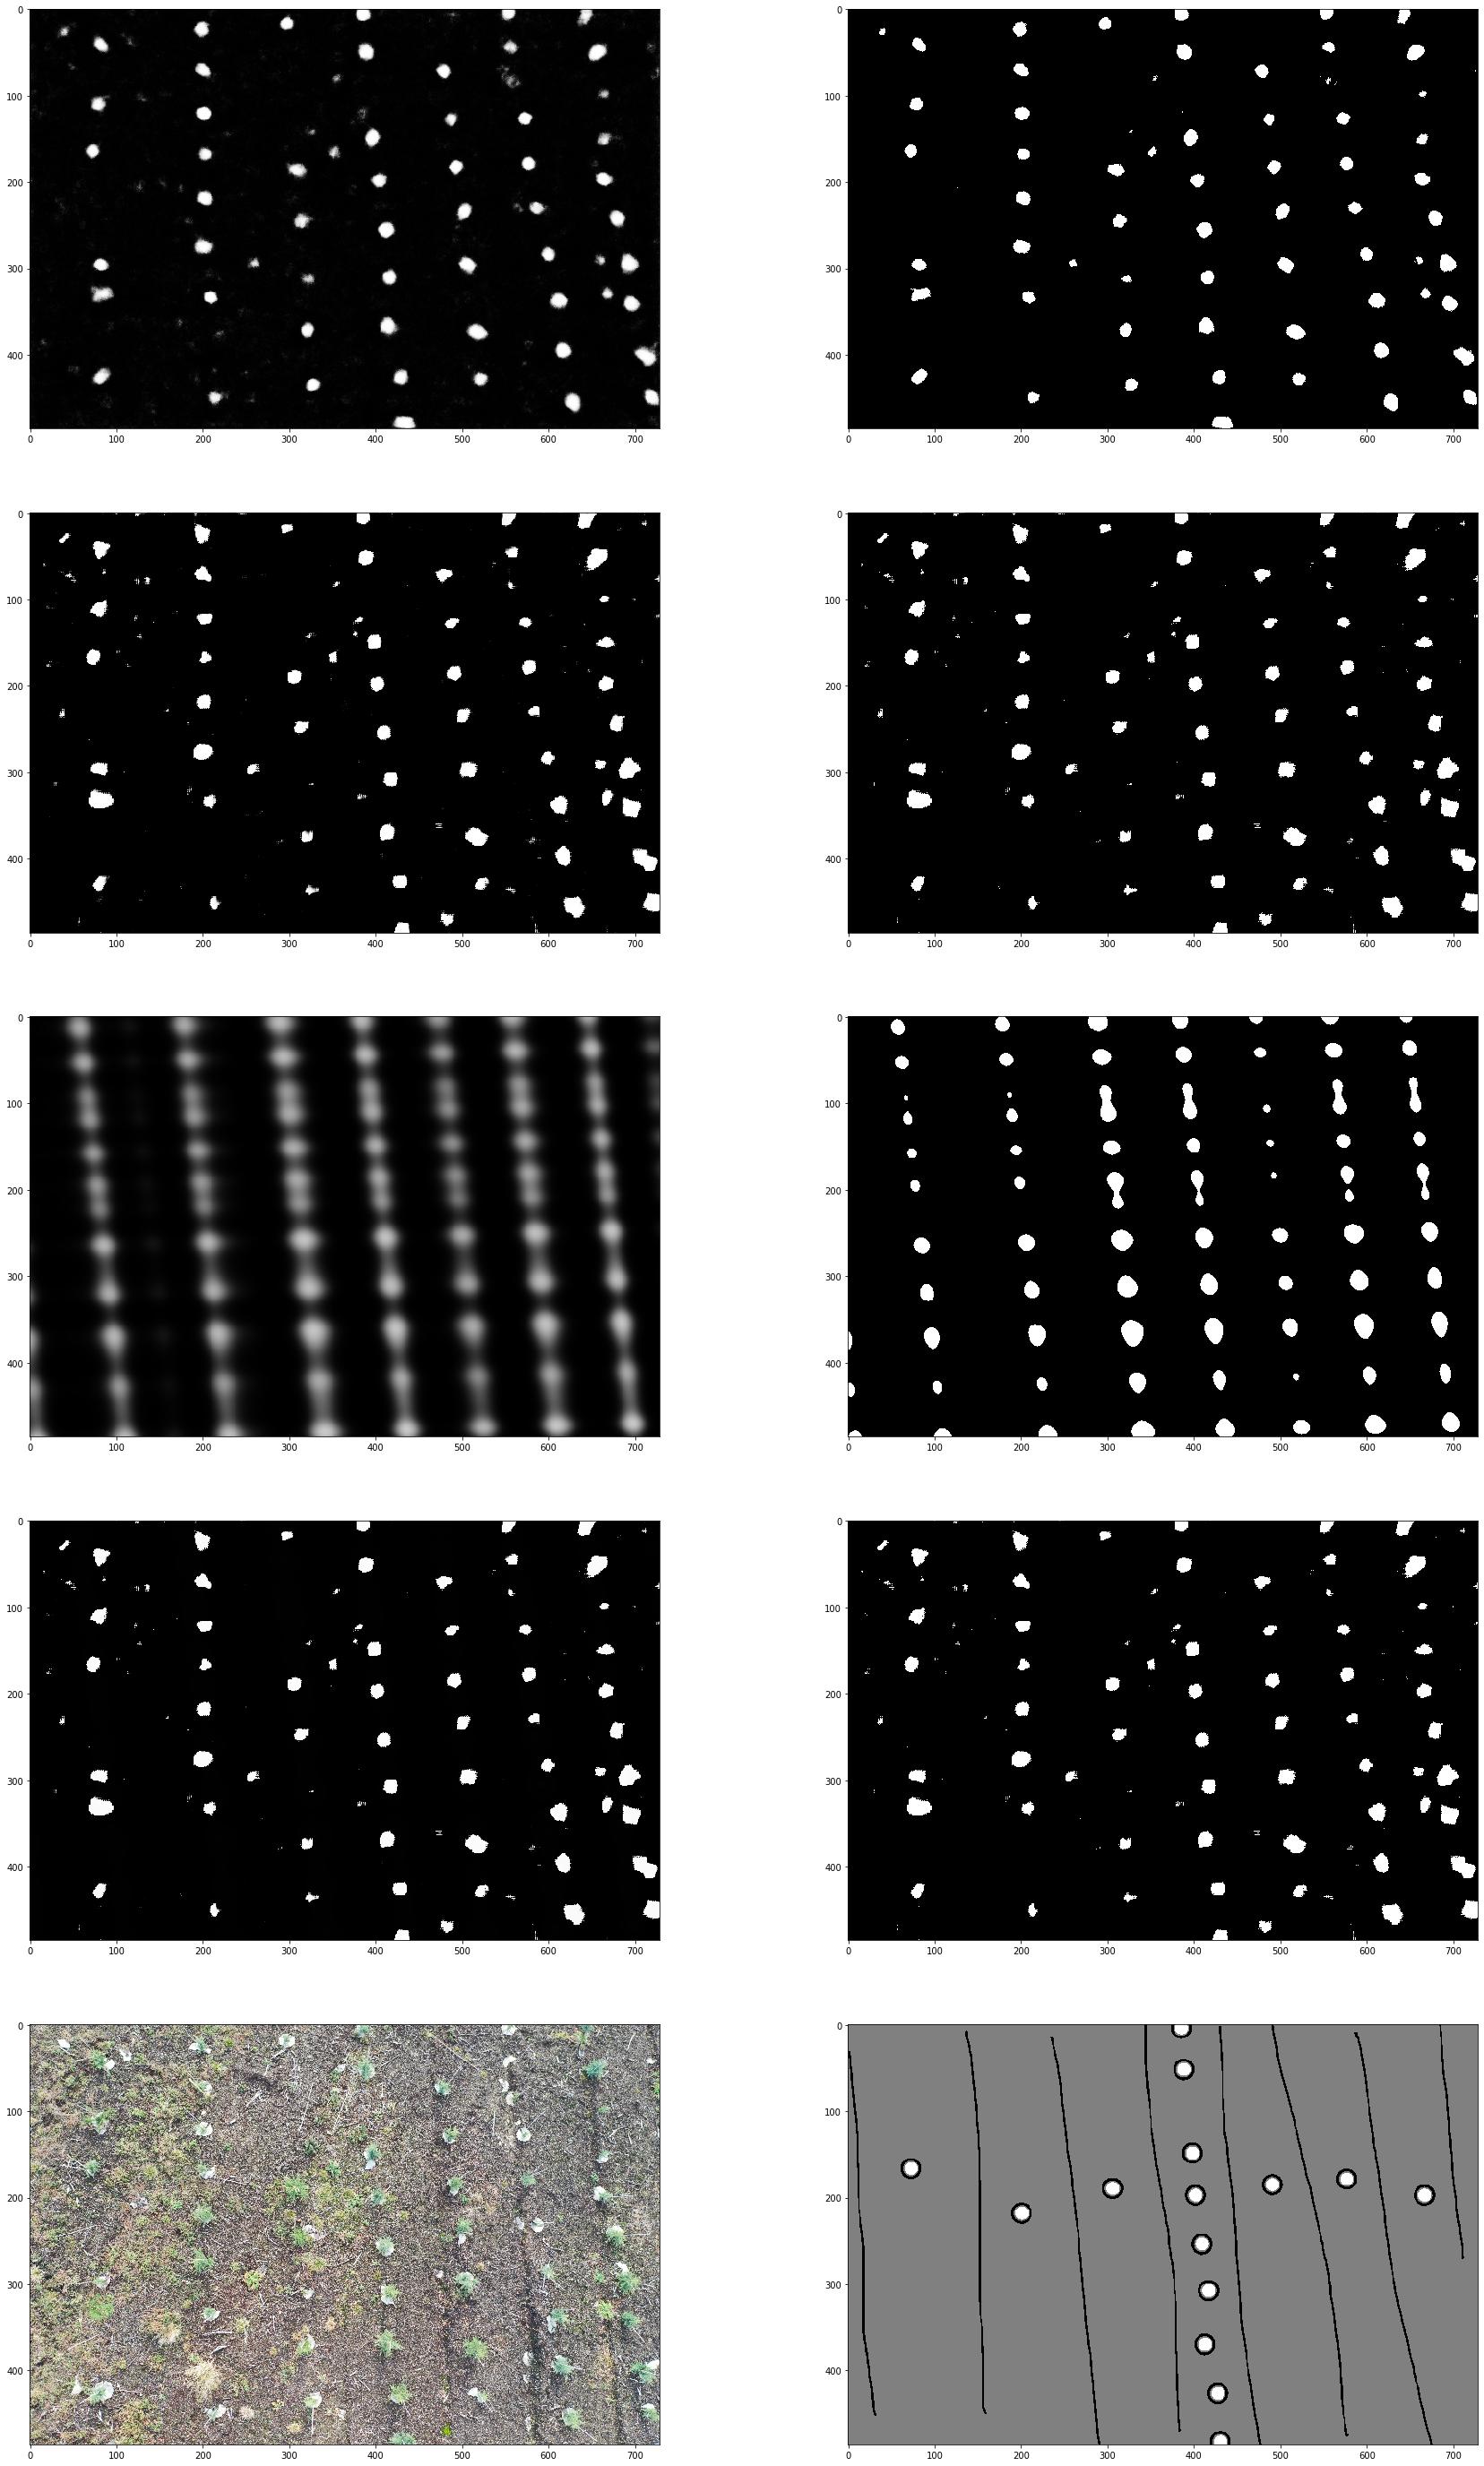

time: 3.32 s


In [25]:
fig, axs = plt.subplots(5, 2, figsize=(30, 5 * 10))

axs[0, 0].imshow(resultImage_UNet, cmap='gray', vmin=0, vmax=255)
axs[0, 1].imshow(resultImage_UNetThresh, cmap='gray', vmin=0, vmax=255)

resultImage = createImageFromYs(ys_eval_Color_PatchNet)
resultImageThresh = cv2.threshold(resultImage, 127, 255, cv2.THRESH_BINARY)[1]
axs[1, 0].imshow(resultImage, cmap='gray', vmin=0, vmax=255)
axs[1, 1].imshow(resultImageThresh, cmap='gray', vmin=0, vmax=255)

resultImage = createImageFromYs(ys_eval_Position_PatchNet)
resultImageThresh = cv2.threshold(resultImage, 127, 255, cv2.THRESH_BINARY)[1]
axs[2, 0].imshow(resultImage, cmap='gray', vmin=0, vmax=255)
axs[2, 1].imshow(resultImageThresh, cmap='gray', vmin=0, vmax=255)

resultImage = createImageFromYs(ys_eval_Combined_PatchNet)
resultImageThresh = cv2.threshold(resultImage, 127, 255, cv2.THRESH_BINARY)[1]
axs[3, 0].imshow(resultImage, cmap='gray', vmin=0, vmax=255)
axs[3, 1].imshow(resultImageThresh, cmap='gray', vmin=0, vmax=255)

axs[4, 0].imshow(np.moveaxis(tensor_xs_eval_Color.numpy().squeeze(0), 0, 2), vmin=0, vmax=255)
axs[4, 1].imshow(tensor_ys_eval.squeeze(0).squeeze(0).numpy() * 255, cmap='gray', vmin=0, vmax=255)
plt.show()

In [26]:
print("resultImageThresh", resultImageThresh.shape, resultImageThresh.size)
print("validationMat", validationMat.shape, validationMat.size)

print((validationMat.flatten() != resultImageThresh.flatten()).sum())

print()
groundTruth = validationMat.flatten() != 0
prediction = resultImageThresh.flatten() != 0
accuracy = sklearn.metrics.accuracy_score(prediction, groundTruth)
print("Overall Accuracy", accuracy)
confusion_matrix = sklearn.metrics.confusion_matrix(groundTruth, prediction)
print("Confusion matrix", confusion_matrix)
tp = float(confusion_matrix[1, 1])
tn = float(confusion_matrix[0, 0])
fp = float(confusion_matrix[0, 1])
fn = float(confusion_matrix[1, 0])
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
print("Sensitivity / Sensitivität", sensitivity)
print("Specificity / Spezifität", specificity)
print("Precision / Positiver Vorhersagewert", precision)
f1 = sklearn.metrics.f1_score(groundTruth != 0, prediction != 0)
print("F1", f1)
jaccard = sklearn.metrics.jaccard_score(groundTruth, prediction)
print("Jaccard", jaccard)
matthewsCorrelationCoefficient = sklearn.metrics.matthews_corrcoef(groundTruth, prediction)
print("Matthews correlation coefficient", matthewsCorrelationCoefficient)



labels = measure.label(validationMat)
validCount = labels.max()
print("validation count ", validCount)

labels = measure.label(resultImageThresh)
#print("prediction count", labels.max())
predCount = np.bincount(labels.flatten())
predCount = len(predCount[np.where(predCount > 50)]) - 1
print("prediction count", predCount)

accuracy = 1 - (abs(validCount - predCount) / validCount)
print("accuracy", accuracy)


#np.set_printoptions(threshold=sys.maxsize)
#print(labels)

resultImageThresh (486, 729) 354294
validationMat (486, 729) 354294
12978

Overall Accuracy 0.9633694050703653
Confusion matrix [[331330   3488]
 [  9490   9986]]
Sensitivity / Sensitivität 0.5127336208667077
Specificity / Spezifität 0.9895823999904426
Precision / Positiver Vorhersagewert 0.7411310672406115
F1 0.6061305007587252
Jaccard 0.4348545549555827
Matthews correlation coefficient 0.5985776598764906
validation count  55
prediction count 60
accuracy 0.9090909090909091
time: 845 ms


In [27]:
print("resultImage_UNetThresh", resultImage_UNetThresh.shape, resultImage_UNetThresh.size)
print("validationMat", validationMat.shape, validationMat.size)

print((validationMat.flatten() != resultImage_UNetThresh.flatten()).sum())

print()
groundTruth = validationMat.flatten() != 0
prediction = resultImage_UNetThresh.flatten() != 0
accuracy = sklearn.metrics.accuracy_score(prediction, groundTruth)
print("Overall Accuracy", accuracy)
confusion_matrix = sklearn.metrics.confusion_matrix(groundTruth, prediction)
print("Confusion matrix", confusion_matrix)
tp = float(confusion_matrix[1, 1])
tn = float(confusion_matrix[0, 0])
fp = float(confusion_matrix[0, 1])
fn = float(confusion_matrix[1, 0])
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
print("Sensitivity / Sensitivität", sensitivity)
print("Specificity / Spezifität", specificity)
print("Precision / Positiver Vorhersagewert", precision)
f1 = sklearn.metrics.f1_score(groundTruth != 0, prediction != 0)
print("F1", f1)
jaccard = sklearn.metrics.jaccard_score(groundTruth, prediction)
print("Jaccard", jaccard)
matthewsCorrelationCoefficient = sklearn.metrics.matthews_corrcoef(groundTruth, prediction)
print("Matthews correlation coefficient", matthewsCorrelationCoefficient)



labels = measure.label(validationMat)
validCount = labels.max()
print("validation count ", validCount)

labels = measure.label(resultImage_UNetThresh)
#print("prediction count", labels.max())
predCount = np.bincount(labels.flatten())
predCount = len(predCount[np.where(predCount > 50)]) - 1
print("prediction count", predCount)

accuracy = 1 - (abs(validCount - predCount) / validCount)
print("accuracy", accuracy)

resultImage_UNetThresh (486, 729) 354294
validationMat (486, 729) 354294
12574

Overall Accuracy 0.9645097009827996
Confusion matrix [[332631   2187]
 [ 10387   9089]]
Sensitivity / Sensitivität 0.4666769357157527
Specificity / Spezifität 0.9934680931132734
Precision / Positiver Vorhersagewert 0.8060482440581767
F1 0.5911160249739853
Jaccard 0.41956331071412084
Matthews correlation coefficient 0.5974657683703954
validation count  55
prediction count 57
accuracy 0.9636363636363636
time: 764 ms
